In [1]:
#Project: Predicting 'V' Beats in ECG using Machine Learning:
#Author : Gokula Krishnan Ramachandran
#Organisation : Biofourmis


# Importing the required modules
%matplotlib inline
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from wfdb import processing



In [2]:
#Supporting functions:
def read_ecg(file_path):
    """
    output: ecg files, get signal, annotated peaks, annotated types
    input: ecg file id
    """
    signals, fields = wfdb.rdsamp(file_path)
    annotation = wfdb.rdann(file_path, 'atr')
    ecg_sig = signals[:,0]
    ecg_type = annotation.symbol
    ecg_peak = annotation.sample
    return ecg_sig, ecg_type, ecg_peak

def plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Train', npeak=10, len_sig=650000, xlim = (0,3000)):
    """
    demo plot ecg signal with annotated peaks, annotated types
    """
    _, ax = plt.subplots()
    for i in range(0, npeak):
        ax.annotate(ecg_type[i], xy=(ecg_peak[i], -2))
    ax.plot(ecg_sig[0:len_sig])
    ax.plot(ecg_peak[0:npeak], ecg_sig[ecg_peak[0:npeak]], '*')
    ax.set_title(title)
    plt.ylim(-2.5,2.1)
    plt.xlim(xlim)

In [3]:
#Creating dataframe from the raw data file
def make_dataframe(filepath):
    
    """
    
    input : ecg file ID
    step 1: use the read_ecg function to extract ecg_sig, ecg_type, and ecg_peak.
    step 2: create a variable time.
    step 3: create a dataframe without signal data (df1).
    step 4: create a second dataframe with only time and signal data (df2).
    step 5: merge the df2 and df1, creating a single dataframe with time, signal, type and peak features.
    step 6: replace the NaN values with 0.
    
    output: single dataframe of time, signal, type and peak features with non-null values. 
    
    
    """
    ecg_sig, ecg_type, ecg_peak = read_ecg(filepath)
    time = np.array(range(1,len(ecg_sig)+1))
    df_1 = pd.DataFrame({'type' : ecg_type, 'time' : ecg_peak, 'peak' :ecg_peak})
    df_2 = pd.DataFrame({'time' :time, 'signal' : ecg_sig})
    df = pd.merge(df_2, df_1, how = 'left', on = 'time')
    df.fillna(0, inplace = True)
    return df

In [4]:
#creating dataframes of all the 6 IDs in the trainig dataset.
df_a1 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a1')
df_a2 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a2')
df_a3 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a3')
df_a4 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a4')
df_a5 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a5')
df_a6 = make_dataframe('/Users/macbookair/Downloads/ECG/database/train/a6')

In [5]:
df_a1.head() # Checking 

,time,signal,type,peak
0,1,-0.145,0,0.0
1,2,-0.145,0,0.0
2,3,-0.145,0,0.0
3,4,-0.145,0,0.0
4,5,-0.145,0,0.0


<h3> Defining Functions. </h3>

In [6]:
# Peak detection
def peak_detector(dataframe):
    """
    input : dataframe generated in the last step
    output : sliced dataframe with data corresponds to the peaks
    
    """
    peak_df = dataframe[dataframe['peak'] > 0]
    return peak_df



In [7]:
def generate_rolling_difference(dataframe):
    """
    input : dataframe generated in the last step.
    output : dataframe with diff_1 column containing the data of the time difference 
             between the adjacent peaks.
    """
    dataframe['diff_1'] = dataframe['peak'].rolling(window=2).apply(np.diff)

In [8]:
def generate_cumsum(dataframe):
    
    """
    input : dataframe generated in the last step.
    output : dataframe with cum_sum column containing the cummulative sum of the diff_1 data.
             between the adjacent peaks.
    """

    dataframe['cum_sum'] = np.cumsum(np.array(dataframe['diff_1']), dtype=float)
   

In [9]:
def make_segments(peak_dataframe, signal_dataframe):
    """
    input : dataframe generated in the previous step and the dataframe containing only 
            the signal data.
    output : dataframe with containing the data of each peak segments as one column, 
             time as rows and signal as the data. 
             
    """
    
    c_data = pd.DataFrame()
    for i in range(0,len(peak_dataframe)-1):
        t0 = peak_dataframe.diff_1[i].astype(int)
        t1 = peak_dataframe.diff_1[i+1].astype(int)
        data = list(signal_dataframe.signal.iloc[t0:t1])
        data1 = pd.DataFrame({i : data})
        c_data = pd.concat([c_data, data1], axis = 1)
        
    return c_data

<h3> Training data preparation. </h3>

In [10]:
# detecting peaks in the training dataset
df_a1_peaks = peak_detector(df_a1)
df_a2_peaks = peak_detector(df_a2)
df_a3_peaks = peak_detector(df_a3)
df_a4_peaks = peak_detector(df_a4)
df_a5_peaks = peak_detector(df_a5)
df_a6_peaks = peak_detector(df_a6)

In [11]:
df_a1_peaks # checking

,time,signal,type,peak
17,18,-0.185,+,18.0
76,77,0.780,N,77.0
369,370,0.875,N,370.0
661,662,0.690,N,662.0
945,946,0.635,N,946.0
...,...,...,...,...
648977,648978,0.825,N,648978.0
649231,649232,0.840,N,649232.0
649483,649484,0.750,N,649484.0
649733,649734,0.830,N,649734.0


In [12]:
# replacing the NaN values with 0
df_a1_peaks.fillna(0, inplace =True)
df_a2_peaks.fillna(0, inplace =True)
df_a3_peaks.fillna(0, inplace =True)
df_a4_peaks.fillna(0, inplace =True)
df_a5_peaks.fillna(0, inplace =True)
df_a6_peaks.fillna(0, inplace =True)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a1_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a2_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [13]:
# reseting the index of the dataframe. 
df_a1_peaks.reset_index(inplace = True)
df_a2_peaks.reset_index(inplace = True)
df_a3_peaks.reset_index(inplace = True)
df_a4_peaks.reset_index(inplace = True)
df_a5_peaks.reset_index(inplace = True)
df_a6_peaks.reset_index(inplace = True)

In [14]:
df_a1_peaks.head() # checking

,index,time,signal,type,peak
0,17,18,-0.185,+,18.0
1,76,77,0.780,N,77.0
2,369,370,0.875,N,370.0
3,661,662,0.690,N,662.0
4,945,946,0.635,N,946.0


In [15]:
# applying the rolling difference fuuction to the training dataset. 
generate_rolling_difference(df_a1_peaks)
generate_rolling_difference(df_a2_peaks)
generate_rolling_difference(df_a3_peaks)
generate_rolling_difference(df_a4_peaks)
generate_rolling_difference(df_a5_peaks)
generate_rolling_difference(df_a6_peaks)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/1729076887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['diff_1'] = dataframe['peak'].rolling(window=2).apply(np.diff)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/1729076887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['diff_1'] = dataframe['peak'].rolling(window=2).apply(np.diff)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/1729076887.py:7: SettingWithCopyWarning: 
A valu

In [16]:
df_a1_peaks # checking

,index,time,signal,type,peak,diff_1
0,17,18,-0.185,+,18.0,NaN
1,76,77,0.780,N,77.0,59.0
2,369,370,0.875,N,370.0,293.0
3,661,662,0.690,N,662.0,292.0
4,945,946,0.635,N,946.0,284.0
...,...,...,...,...,...,...
2269,648977,648978,0.825,N,648978.0,245.0
2270,649231,649232,0.840,N,649232.0,254.0
2271,649483,649484,0.750,N,649484.0,252.0
2272,649733,649734,0.830,N,649734.0,250.0


In [17]:
# replacing the NaN values with 0
df_a1_peaks.fillna(0, inplace =True)
df_a2_peaks.fillna(0, inplace =True)
df_a3_peaks.fillna(0, inplace =True)
df_a4_peaks.fillna(0, inplace =True)
df_a5_peaks.fillna(0, inplace =True)
df_a6_peaks.fillna(0, inplace =True)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a1_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a2_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/38502387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [18]:
# applying the cummulative  fuuction to the training dataset. 
generate_cumsum(df_a1_peaks)
generate_cumsum(df_a2_peaks)
generate_cumsum(df_a3_peaks)
generate_cumsum(df_a4_peaks)
generate_cumsum(df_a5_peaks)
generate_cumsum(df_a6_peaks)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/376369680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cum_sum'] = np.cumsum(np.array(dataframe['diff_1']), dtype=float)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/376369680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cum_sum'] = np.cumsum(np.array(dataframe['diff_1']), dtype=float)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/376369680.py:9: SettingWithCopyWarning: 
A

In [19]:
df_a1_peaks.head() # checking

,index,time,signal,type,peak,diff_1,cum_sum
0,17,18,-0.185,+,18.0,0.0,0.0
1,76,77,0.780,N,77.0,59.0,59.0
2,369,370,0.875,N,370.0,293.0,352.0
3,661,662,0.690,N,662.0,292.0,644.0
4,945,946,0.635,N,946.0,284.0,928.0


In [20]:
df_a1_peaks.shape # checking the dimension of the dataframes

(2274, 7)

In [21]:
df_a2_peaks.shape

(1874, 7)

In [22]:
df_a3_peaks.shape

(2098, 7)

In [23]:
df_a4_peaks.shape

(2094, 7)

In [24]:
df_a5_peaks.shape

(2763, 7)

In [25]:
df_a6_peaks.shape

(3400, 7)

<p2> Checking the whether the created data in aligning properly with the raw data </p2>

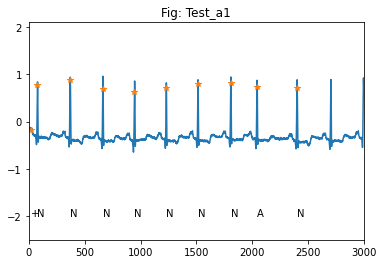

In [26]:
ecg_sig_a1, ecg_type_a1, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a1')
plot_ecg(ecg_sig_a1, ecg_type_a1, df_a1_peaks['index'], title='Fig: Test_a1', npeak=10, len_sig=3000, xlim = (0,3000))

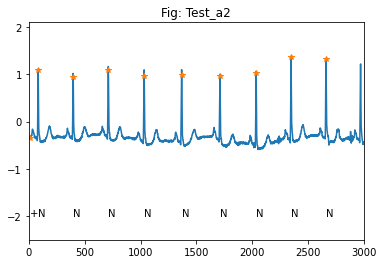

In [27]:
ecg_sig_a2, ecg_type_a2, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a2')
plot_ecg(ecg_sig_a2, ecg_type_a2, df_a2_peaks['index'], title='Fig: Test_a2', npeak=10, len_sig=3000)

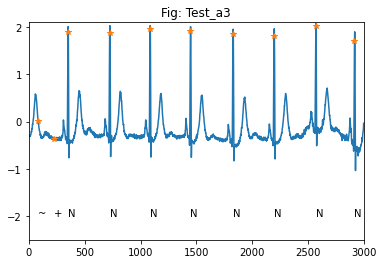

In [28]:
ecg_sig_a3, ecg_type_a3, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a3')
plot_ecg(ecg_sig_a3, ecg_type_a3, df_a3_peaks['index'], title='Fig: Test_a3', npeak=10, len_sig=3000)

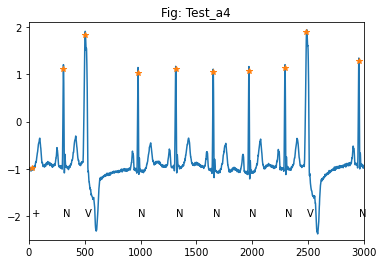

In [29]:
ecg_sig_a4, ecg_type_a4, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a4')
plot_ecg(ecg_sig_a4, ecg_type_a4, df_a4_peaks['index'], title='Fig: Test_a4', npeak=10, len_sig=3000)

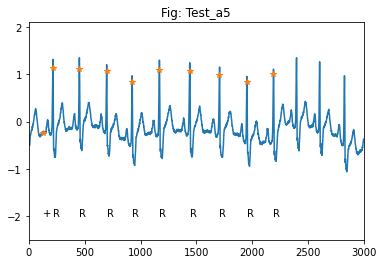

In [30]:
ecg_sig_a5, ecg_type_a5, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a5')
plot_ecg(ecg_sig_a5, ecg_type_a5, df_a5_peaks['index'], title='Fig: Test_a5', npeak=10, len_sig=3000)

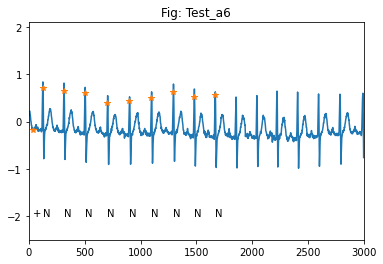

In [31]:
ecg_sig_a6, ecg_type_a6, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/train/a6')
plot_ecg(ecg_sig_a6, ecg_type_a6, df_a6_peaks['index'], title='Fig: Test_a6', npeak=10, len_sig=3000)

In [32]:
df_a2_peaks.head() # checking

,index,time,signal,type,peak,diff_1,cum_sum
0,6,7,-0.345,+,7.0,0.0,0.0
1,82,83,1.085,N,83.0,76.0,76.0
2,395,396,0.945,N,396.0,313.0,389.0
3,710,711,1.085,N,711.0,315.0,704.0
4,1031,1032,0.975,N,1032.0,321.0,1025.0


In [33]:
data_a1 = make_segments(df_a1_peaks, df_a1) # generating peak segment data

In [34]:
data_a1 = data_a1[0:278].T # sliced and transposed to make time as features.

In [35]:
data_a1.shape # checking the transposed data

(2273, 234)

In [36]:
data_a1.head() # checking the transposed data

,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,229,230,231,232,233
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.315,-0.320,-0.335,-0.360,-0.385,-0.385,-0.405,-0.455,-0.485,-0.485,...,-0.305,-0.29,-0.3,-0.3,-0.305,-0.305,-0.29,-0.28,-0.295,-0.305
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# generating peak segment data
data_a2 = make_segments(df_a2_peaks, df_a2)
data_a3 = make_segments(df_a3_peaks, df_a3)
data_a4 = make_segments(df_a4_peaks, df_a4)
data_a5 = make_segments(df_a5_peaks, df_a5)
data_a6 = make_segments(df_a6_peaks, df_a6)

In [38]:
data_a2.shape #checking

(333, 1873)

In [39]:
data_a3.shape #checking

(390, 2097)

In [40]:
data_a4.shape #checking

(427, 2093)

In [41]:
data_a5.shape #checking 

(160, 2762)

In [42]:
data_a6.shape #checking

(246, 3399)

In [43]:
# sliced and transposed to make time as feat
data_a2 = data_a2[0:278].T
data_a3 = data_a3[0:278].T
data_a4 = data_a4[0:278].T
data_a5 = data_a5[0:278].T
data_a6 = data_a6[0:278].T

In [44]:
data_a2.shape #checking

(1873, 278)

In [45]:
data_a2.head() #checking

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-0.345,-0.345,-0.345,-0.345,-0.345,-0.345,-0.345,-0.345,-0.330,-0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.350,-0.210,-0.010,0.245,0.530,0.850,1.085,1.065,0.815,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.335,-0.320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.305,-0.310,-0.315,-0.320,-0.350,-0.315,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.320,-0.320,-0.320,-0.320,-0.320,-0.310,-0.310,-0.315,-0.315,-0.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_a3.shape #checking

(2097, 278)

In [47]:
data_a4.shape #checking

(2093, 278)

In [48]:
data_a5.shape #checking

(2762, 160)

In [49]:
data_a6.shape #checking

(3399, 246)

<p> Feature Engineering </p>

In [50]:
#adding peak type data to the peak segment dataframes
data_a1 ['type'] = df_a1_peaks.type
data_a2 ['type'] = df_a2_peaks.type
data_a3 ['type'] = df_a3_peaks.type
data_a4 ['type'] = df_a4_peaks.type
data_a5 ['type'] = df_a5_peaks.type
data_a6 ['type'] = df_a6_peaks.type

In [51]:
#adding peak interval data to the peak segment dataframes
data_a1 ['peak_interval'] = df_a1_peaks.diff_1
data_a2 ['peak_interval'] = df_a2_peaks.diff_1
data_a3 ['peak_interval'] = df_a3_peaks.diff_1
data_a4 ['peak_interval'] = df_a4_peaks.diff_1
data_a5 ['peak_interval'] = df_a5_peaks.diff_1
data_a6 ['peak_interval'] = df_a6_peaks.diff_1

In [52]:
data_a1.head() # checking

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,type,peak_interval
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+,0.0
1,-0.315,-0.320,-0.335,-0.360,-0.385,-0.385,-0.405,-0.455,-0.485,-0.485,...,-0.3,-0.3,-0.305,-0.305,-0.29,-0.28,-0.295,-0.305,N,59.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,293.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,292.0
4,-0.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,284.0


In [53]:
# checking for NaN values 
data_a1.isnull().sum()

0                1189
1                1285
2                1378
3                1463
4                1538
                 ... 
231              2272
232              2272
233              2272
type                0
peak_interval       0
Length: 236, dtype: int64

In [54]:
#concatinating all the training data into one dataframe.
train = pd.concat([data_a1, data_a2, data_a3, data_a4, data_a5, data_a6], ignore_index=True)

In [55]:
train.shape # Checking the shape of the merged training dataframe. 

(14497, 280)

In [56]:
train.head() # Checking the data of the merged training dataframe. 

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.315,-0.320,-0.335,-0.360,-0.385,-0.385,-0.405,-0.455,-0.485,-0.485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
train.tail() # Checking the data of the merged training dataframe. 

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
14492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14494,0.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14496,0.225,0.24,0.265,0.26,0.265,0.25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
train[train['type'] == 'V'] # slicing the data corresponding to the V type beat.

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
1907,-0.300,-0.300,-0.290,-0.295,-0.290,-0.285,-0.275,-0.255,-0.250,-0.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4254,-0.295,-0.330,-0.340,-0.295,-0.285,-0.295,-0.330,-0.345,-0.345,-0.320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4257,-0.300,-0.290,-0.290,-0.260,-0.265,-0.275,-0.280,-0.285,-0.265,-0.240,...,0.235,0.25,0.27,0.3,0.355,0.42,0.465,0.495,0.515,0.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14435,-0.185,-0.165,-0.130,-0.140,-0.135,-0.140,-0.155,-0.135,-0.115,-0.090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14450,-0.185,-0.185,-0.165,-0.130,-0.140,-0.135,-0.140,-0.155,-0.135,-0.115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14470,-0.170,-0.185,-0.185,-0.165,-0.130,-0.140,-0.135,-0.140,-0.155,-0.135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
train['peak_interval'] # checking peak interval column.

0          0.0
1         59.0
2        293.0
3        292.0
4        284.0
         ...  
14492    223.0
14493    208.0
14494    196.0
14495    197.0
14496    184.0
Name: peak_interval, Length: 14497, dtype: float64

In [60]:
train.fillna(0, inplace = True) # replacing the NaN values by 0.

In [61]:
train.head() # checking the training dataset.

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.315,-0.320,-0.335,-0.360,-0.385,-0.385,-0.405,-0.455,-0.485,-0.485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.290,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# creating the mean column containing the mean statistic of the signals of each peak segment.
train['mean'] = train.mean(axis=1) 

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3202258035.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train['mean'] = train.mean(axis=1)


In [63]:
# creating the median column containing the median statistic of the signals of each peak segment.
train['median'] = train.median(axis=1)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/2937216698.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train['median'] = train.median(axis=1)


In [64]:
# creating the sum column containing the sum of the signals of each peak segment.
train['sum'] = train.sum(axis=1)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/78618230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train['sum'] = train.sum(axis=1)


Tried to include other point statistics as features but they did not improve the performance of the model so NOT used.

In [65]:
#train['sem'] = train.sem(axis=1)

In [66]:
#train['range'] = train.max(axis=1) - train.min(axis=1) 

In [67]:
#train['variance'] = train.var(axis=1) 

In [68]:
#train['std'] = train.std(axis=1) 

In [69]:
train.head() # checking the amended dataframe.

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,mean,median,sum
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.046326,0.000,-12.971326
1,-0.315,-0.320,-0.335,-0.360,-0.385,-0.385,-0.405,-0.455,-0.485,-0.485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030842,-0.305,-8.940842
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.050179,0.000,294.050179
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.046595,0.000,293.046595
4,-0.290,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.016882,0.000,284.726882


In [70]:
train.type.unique() # finding the unique values in the type column.

array(['+', 'N', 'A', 'V', '~', '|', 'Q', 'R', '"', 'F'], dtype=object)

In [71]:
# As the task is to build a binary classifier the V beat is set to 1 and all the others were set to 0.
train.type.replace('V' , 1, inplace = True)
train.type.replace(['+', 'N', 'A', '~', '|', 'Q', 'R', '"', 'F'] , 0, inplace = True)

In [72]:
train.type.unique() # checking the binary encoding

array([0, 1])

<p> Balancing the training dataset. </p>

In [73]:
counts = train.type.value_counts(normalize = True)*100
counts # checking whether the data is balanced or imbalanced.

0    92.212182
1     7.787818
Name: type, dtype: float64

In [74]:
train.type.value_counts()

0    13368
1     1129
Name: type, dtype: int64

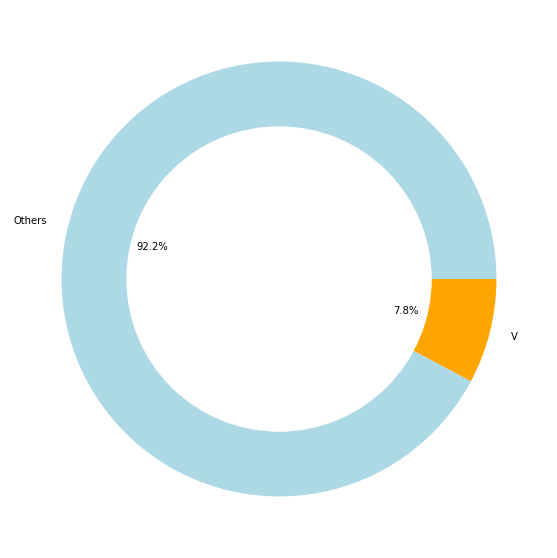

In [75]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(counts, labels=['Others','V'], colors=['lightblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

The data is imbalanced so inorder to make is balanced I am using the resample method from sklearn module.

In [76]:
from sklearn.utils import resample
df_0=train[train['type']==0]
df_1=train[train['type']==1]


df_0_resample=resample(df_0,replace=True,n_samples=13368,random_state=1)
df_1_resample=resample(df_1,replace=True,n_samples=13368,random_state=2)


train_rs=pd.concat([df_0_resample,df_1_resample])


In [77]:
count_rs = train_rs.type.value_counts(normalize = True)
count_rs

0    0.5
1    0.5
Name: type, dtype: float64

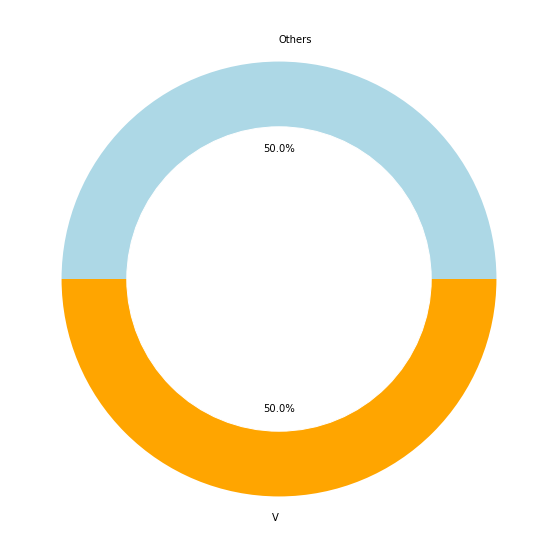

In [78]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(count_rs, labels=['Others','V'], colors=['lightblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

The data is now balanced after resampling.

<h3> Preparing the test data, following the same steps used in the training data preparation EXCEPT the merging all the data and balancing.</h3>

In [79]:
df_b1 = make_dataframe('/Users/macbookair/Downloads/ECG/database/test/b1')
df_b2 = make_dataframe('/Users/macbookair/Downloads/ECG/database/test/b2')

In [80]:
df_b1_peaks = peak_detector(df_b1)
df_b2_peaks = peak_detector(df_b2)

In [81]:
df_b1_peaks.fillna(0, inplace =True)
df_b2_peaks.fillna(0, inplace =True)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3414306109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3414306109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b2_peaks.fillna(0, inplace =True)


In [82]:
df_b1_peaks.reset_index(inplace = True)
df_b2_peaks.reset_index(inplace = True)

In [83]:
generate_rolling_difference(df_b1_peaks)
generate_rolling_difference(df_b2_peaks)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/1729076887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['diff_1'] = dataframe['peak'].rolling(window=2).apply(np.diff)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/1729076887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['diff_1'] = dataframe['peak'].rolling(window=2).apply(np.diff)


In [84]:
df_b1_peaks.fillna(0, inplace =True)
df_b2_peaks.fillna(0, inplace =True)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3414306109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1_peaks.fillna(0, inplace =True)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3414306109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b2_peaks.fillna(0, inplace =True)


In [85]:
generate_cumsum(df_b1_peaks)
generate_cumsum(df_b2_peaks)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/376369680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cum_sum'] = np.cumsum(np.array(dataframe['diff_1']), dtype=float)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/376369680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cum_sum'] = np.cumsum(np.array(dataframe['diff_1']), dtype=float)


In [86]:
data_b1 = make_segments(df_b1_peaks, df_b1)
data_b2 = make_segments(df_b2_peaks, df_b2)

<AxesSubplot:>

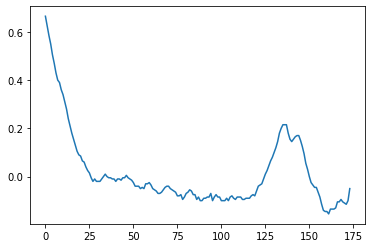

In [87]:
data_b2[3050].plot()

In [88]:
data_b1.shape

(370, 2096)

In [89]:
df_b1_peaks.head()

,index,time,signal,type,peak,diff_1,cum_sum
0,159,160,0.565,?,160.0,0.0,0.0
1,432,433,0.330,?,433.0,273.0,273.0
2,725,726,0.545,?,726.0,293.0,566.0
3,1060,1061,0.565,?,1061.0,335.0,901.0
4,1365,1366,0.505,?,1366.0,305.0,1206.0


In [90]:
data_b2.shape

(278, 3080)

In [91]:
df_b2_peaks.head()

,index,time,signal,type,peak,diff_1,cum_sum
0,41,42,-2.150,?,42.0,0.0,0.0
1,319,320,1.655,?,320.0,278.0,278.0
2,510,511,-1.700,?,511.0,191.0,469.0
3,748,749,1.285,?,749.0,238.0,707.0
4,963,964,1.315,?,964.0,215.0,922.0


In [92]:
df_b1_peaks['index']

0          159
1          432
2          725
3         1060
4         1365
         ...  
2092    648463
2093    648776
2094    649107
2095    649331
2096    649760
Name: index, Length: 2097, dtype: int64

In [93]:
df_b2_peaks['index']

0           41
1          319
2          510
3          748
4          963
         ...  
3076    649089
3077    649236
3078    649517
3079    649729
3080    649945
Name: index, Length: 3081, dtype: int64

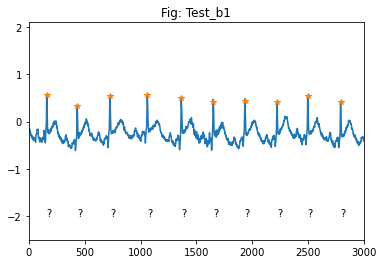

In [94]:
ecg_sig_b1, ecg_type_b1, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/test/b1')
plot_ecg(ecg_sig_b1, ecg_type_b1, df_b1_peaks['index'], title='Fig: Test_b1', npeak=10, len_sig=3000)

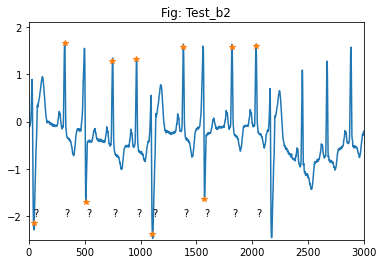

In [95]:
ecg_sig_b2, ecg_type_b2, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/test/b2')
plot_ecg(ecg_sig_b2, ecg_type_b2, df_b2_peaks['index'], title='Fig: Test_b2', npeak=10, len_sig=3000)

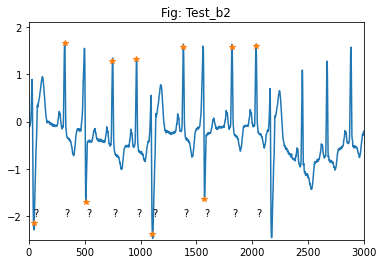

In [96]:
plot_ecg(ecg_sig_b2, ecg_type_b2, df_b2_peaks['index'], title='Fig: Test_b2', npeak=10, len_sig=3000)

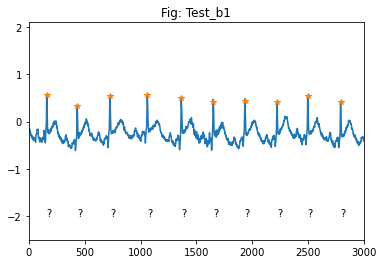

In [97]:
plot_ecg(ecg_sig_b1, ecg_type_b1, df_b1_peaks['index'], title='Fig: Test_b1', npeak=10, len_sig=3000)

In [98]:
data_b1 = data_b1[0:278].T
data_b2 = data_b2[0:278].T

In [99]:
data_b1.head()

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-0.155,-0.155,-0.155,-0.155,-0.155,-0.155,-0.155,-0.155,-0.170,-0.175,...,-0.32,-0.31,-0.295,-0.275,-0.29,NaN,NaN,NaN,NaN,NaN
1,-0.320,-0.350,-0.350,-0.355,-0.340,-0.345,-0.320,-0.340,-0.375,-0.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.435,-0.435,-0.415,-0.400,-0.385,-0.400,-0.420,-0.450,-0.455,-0.465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
data_b1.shape

(2096, 278)

In [101]:
data_b2.shape

(3080, 278)

In [102]:
data_b1.iloc[18]

0     -0.390
1     -0.380
2     -0.370
3     -0.355
4     -0.365
       ...  
273      NaN
274      NaN
275      NaN
276      NaN
277      NaN
Name: 18, Length: 278, dtype: float64

In [103]:
data_b2.head()

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.09,...,0.18,0.2,0.215,0.215,0.215,0.18,0.155,0.145,0.155,0.165
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.050,-0.030,-0.030,-0.025,-0.035,-0.050,-0.055,-0.060,-0.070,-0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
data_b1 ['type'] = df_b1_peaks.type
data_b2 ['type'] = df_b2_peaks.type

In [105]:
data_b1 ['peak_interval'] = df_b1_peaks.diff_1
data_b2 ['peak_interval'] = df_b2_peaks.diff_1
data_b1['mean'] = data_b1.mean(axis=1)
data_b2['mean'] = data_b2.mean(axis=1)
data_b1['median'] = data_b1.median(axis=1)
data_b2['median'] = data_b2.median(axis=1)
data_b1['sum'] = data_b1.sum(axis=1)
data_b2['sum'] = data_b2.sum(axis=1)
#data_b1['sem'] = data_b1.sem(axis=1)
#data_b2['sem'] = data_b2.sem(axis=1)
#data_b1['range'] = data_b1.max(axis=1) - data_b1.min(axis=1)
#data_b2['range'] = data_b2.max(axis=1) - data_b2.min(axis=1)
#data_b1['variance'] = data_b1.var(axis=1)
#data_b2['variance'] = data_b2.var(axis=1)
#data_b1['std'] = data_b1.std(axis=1)
#data_b2['std'] = data_b2.std(axis=1)

/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3016613730.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_b1['mean'] = data_b1.mean(axis=1)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3016613730.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_b2['mean'] = data_b2.mean(axis=1)
/var/folders/3q/rmzxschd5zj38nbjzwh53z380000gn/T/ipykernel_5403/3016613730.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_b1['median'] = data_b1.med

In [106]:
data_b1.fillna(0, inplace = True)
data_b2.fillna(0, inplace = True)

In [107]:
data_b1.shape

(2096, 283)

In [108]:
data_b2.shape

(3080, 283)

In [109]:
data_b2

,0,1,2,3,4,5,6,7,8,9,...,273,274,275,276,277,type,peak_interval,mean,median,sum
0,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.095,-0.090,...,0.18,0.155,0.145,0.155,0.165,?,0.0,0.002294,-0.0100,0.632294
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,278.0,278.000000,278.0000,834.000000
2,-0.050,-0.030,-0.030,-0.025,-0.035,-0.050,-0.055,-0.060,-0.070,-0.070,...,0.00,0.000,0.000,0.000,0.000,?,191.0,3.910521,-0.0700,191.545521
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,238.0,238.000000,238.0000,714.000000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,215.0,215.000000,215.0000,645.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,220.0,220.000000,220.0000,660.000000
3076,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,217.0,217.000000,217.0000,651.000000
3077,0.280,0.240,0.210,0.180,0.155,0.130,0.105,0.090,0.085,0.065,...,0.00,0.000,0.000,0.000,0.000,?,147.0,1.082741,-0.0350,147.217741
3078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,?,281.0,281.000000,281.0000,843.000000


<h3> Model building: </h3>

In [110]:
#defining the target and the feature columns.
target = 'type'
features = [c for c in train_rs.columns if c != target]

In [111]:
# defining X and y variable data for model fitting
X = train_rs[features]
y = train_rs[target]

<p> Logistic Regression model: </p>

In [112]:
logr = LogisticRegression()

In [113]:
logr.fit(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [114]:
acurracy_train = logr.score(X, y)
print (f'Acurracy of training data: {acurracy_train:.4f}')

Acurracy of training data: 0.9389


/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<p> Naive Bayes Model: </p>

In [115]:
nb_model = GaussianNB()

nb_model.fit(X, y)
nb_model.score(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8710353081986835

<p>KNN Model: </p>

In [116]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X, y)
knn.score(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9514886295631358

<p> Decision Tree Model: </p>

In [117]:
dt = DecisionTreeClassifier(random_state=0)

In [118]:
dt.fit(X,y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeClassifier(random_state=0)

In [119]:
dt.get_depth()

37

In [120]:
dt.predict(X)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([0, 0, 0, ..., 1, 1, 1])

In [121]:
dt.score(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9626346499102334

<p> Random Forest Model: </p>

In [122]:
rf = RandomForestClassifier(max_depth=2, random_state=0)

In [123]:
rf.fit(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(max_depth=2, random_state=0)

In [124]:
rf.predict(X)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([0, 0, 0, ..., 1, 0, 1])

In [125]:
rf.score(X, y)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9170780969479354

In [126]:
performance = pd.DataFrame({'Model' : ['Logistic Regression', 'Naive Bayes','KNN', 
                                       'Decision Tree', 'Random Forest'], 
                            'Accuracy': [94,87,95,96,92]})



Text(0.5, 0, 'Accuracy')

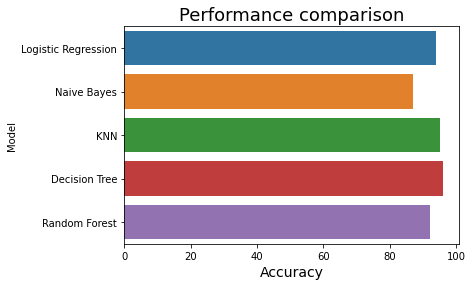

In [127]:
#performance plot
sns.barplot(x="Accuracy", y="Model", data=performance)
plt.title ('Performance comparison', fontsize = 18)
plt.xlabel('Accuracy', fontsize = 14)


<p> Decision tree model is relatively more accuracy comapred to other fitted models </p>

<p> K-Fold Cross Validation: </p>

In [128]:
# Cross validation to check for overfitting for the decision tree model.
scores = cross_val_score(dt, X, y, cv=10)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

In [129]:
# CV scores
scores

array([0.9540015 , 0.95961107, 0.95624533, 0.95998504, 0.95961107,
       0.96484667, 0.96258885, 0.95660307, 0.96371119, 0.95922185])

In [130]:
# cross validation scores are consistent showing minimum likelihood of over fitting
cross_val = pd.DataFrame ({'Iterations' : [1,2,3,4,5,6,7,8,9,10], 'CV scores' : scores})
cross_val

,Iterations,CV scores
0,1,0.954001
1,2,0.959611
2,3,0.956245
3,4,0.959985
4,5,0.959611
5,6,0.964847
6,7,0.962589
7,8,0.956603
8,9,0.963711
9,10,0.959222


<h3> Predicting the test data (applying the Decision tree model): </h3>

In [131]:
X_b1 = data_b1[features] # preparing test data for prediction

In [132]:
X_b2 = data_b2[features]

In [133]:
b1_prediction = dt.predict(X_b1) #predicting the type of beat in test data.

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [134]:
b1_prediction.shape

(2096,)

In [135]:
b2_prediction = dt.predict(X_b2) #predicting the type of beat in test data.

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [136]:
b2_prediction.shape

(3080,)

In [137]:
prediction_test_b1 = pd.DataFrame({'Prediction_b1' : b1_prediction})
prediction_test_b2 = pd.DataFrame({'Prediction_b2' : b2_prediction})

In [138]:
prediction_test_b1

,Prediction_b1
0,0
1,0
2,0
3,0
4,0
...,...
2091,0
2092,0
2093,0
2094,0


In [139]:
#replacing the 1s and 0s with V and ? respectively.
prediction_test_b1.Prediction_b1.replace(1,'V',inplace = True)
prediction_test_b1.Prediction_b1.replace(0,'?', inplace = True)

In [140]:
prediction_test_b1

,Prediction_b1
0,?
1,?
2,?
3,?
4,?
...,...
2091,?
2092,?
2093,?
2094,?


In [141]:
#replacing the 1s and 0s with V and ? respectively.
prediction_test_b2.Prediction_b2.replace(1,'V', inplace = True)
prediction_test_b2.Prediction_b2.replace(0,'?', inplace = True)

In [142]:
prediction_test_b2

,Prediction_b2
0,?
1,?
2,V
3,?
4,?
...,...
3075,?
3076,?
3077,V
3078,?


In [143]:
# b2 predictions
prediction_test_b2.Prediction_b2.value_counts()

?    2309
V     771
Name: Prediction_b2, dtype: int64

In [144]:
# b1 predictions
prediction_test_b1.Prediction_b1.value_counts()

?    1807
V     289
Name: Prediction_b1, dtype: int64

In [145]:
ecg_sig_b1, ecg_type, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/test/b1')


In [146]:
ecg_sig_b2, ecg_type, ecg_peak = read_ecg('/Users/macbookair/Downloads/ECG/database/test/b2')


In [147]:
ecg_type_b1 = np.array(prediction_test_b1.Prediction_b1)
ecg_type_b1[18]

'?'

In [148]:
ecg_type_b2 = np.array(prediction_test_b2.Prediction_b2)
ecg_type_b2[8]

'?'

In [149]:
type(ecg_type_b2)

numpy.ndarray

In [150]:
type(ecg_type_b1)

numpy.ndarray

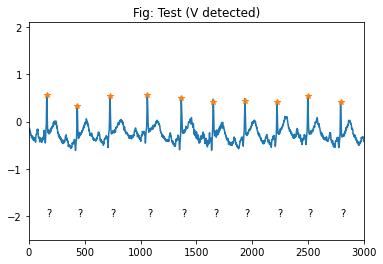

In [151]:
#prediction results for b1.
plot_ecg(ecg_sig_b1, ecg_type_b1 , df_b1_peaks['index'],title='Fig: Test (V detected)', len_sig=650000, npeak = 2096, xlim = (0,3000))


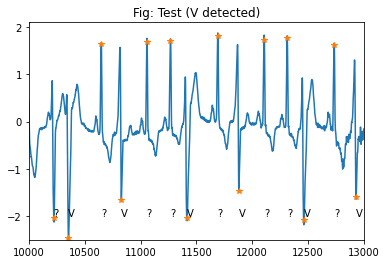

In [152]:
#prediction results for b2.
plot_ecg(ecg_sig_b2, ecg_type_b2 , df_b2_peaks['index'],title='Fig: Test (V detected)', npeak = 2000, len_sig=650000, xlim = (10000,13000))


<h3> Preparation and exporting the results in wfdb format (.test). <h3>

In [153]:
prediction_test_b2[prediction_test_b2['Prediction_b2'] == 'V']

,Prediction_b2
2,V
5,V
7,V
10,V
14,V
...,...
3061,V
3063,V
3069,V
3073,V


In [154]:
prediction_test_b1[prediction_test_b1['Prediction_b1'] == 'V']

,Prediction_b1
20,V
21,V
24,V
28,V
30,V
...,...
2062,V
2064,V
2072,V
2081,V


In [155]:
b2_ecg_peaks = np.array(df_b2_peaks['index'])

In [156]:
b2_ecg_peaks

array([    41,    319,    510, ..., 649517, 649729, 649945])

In [157]:
ecg_type_b2

array(['?', '?', 'V', ..., 'V', '?', '?'], dtype=object)

In [158]:
ecg_type_b2 = np.append (ecg_type_b2,['?'])

In [159]:
ecg_type_b2

array(['?', '?', 'V', ..., '?', '?', '?'], dtype=object)

In [160]:
b2_ecg_peaks.shape

(3081,)

In [161]:
ecg_type_b2.shape

(3081,)

In [162]:
ecg_type_b1

array(['?', '?', '?', ..., '?', '?', '?'], dtype=object)

In [163]:
ecg_type_b1 = np.append (ecg_type_b1,['?'])

In [164]:
b1_ecg_peaks = np.array(df_b1_peaks['index'])

In [165]:
b1_ecg_peaks

array([   159,    432,    725, ..., 649107, 649331, 649760])

In [166]:
b1_ecg_peaks.shape

(2097,)

In [167]:
ecg_type_b1.shape

(2097,)

In [168]:
wfdb.wrann('b2', 'test', b2_ecg_peaks, ecg_type_b2, write_dir='/Users/macbookair/Downloads/ECG/')

In [169]:
wfdb.wrann('b1', 'test', b1_ecg_peaks, ecg_type_b1, write_dir='/Users/macbookair/Downloads/ECG/')